In [ ]:
# IMPORTACIÓN DE LIBRERÍAS

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

In [ ]:
# CARGA Y PREVISUALIZACIÓN DEL NUEVO DATASET

df = pd.read_csv("/content/desercion_escolar_simulado.csv")

print("✅ Dataset cargado correctamente.")
print(df.head(), "\n")
print("Dimensiones:", df.shape)

✅ Dataset cargado correctamente.
   Sexo  Edad  Grado  Nivel_socioeconomico  Situacion_familiar  Conectividad  \
0     0    18      4                     1                   0             1   
1     1    19      3                     1                   0             1   
2     0    13      3                     0                   0             1   
3     0    13      4                     1                   0             0   
4     0    13      2                     0                   0             0   

   Asistencia  Inasistencias  Promedio_academico  Rendimiento  Trabajo  \
0        64.3             17                7.11            1        0   
1        85.3              7                7.12            1        0   
2        64.2             19                7.74            1        0   
3        81.8             15                4.56            0        1   
4       100.0              2                8.20            2        1   

   Distancia_escuela  Extraescolares  Rie

/tmp/ipython-input-3990734947.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Riesgo_desercion", data=df, palette="pastel")


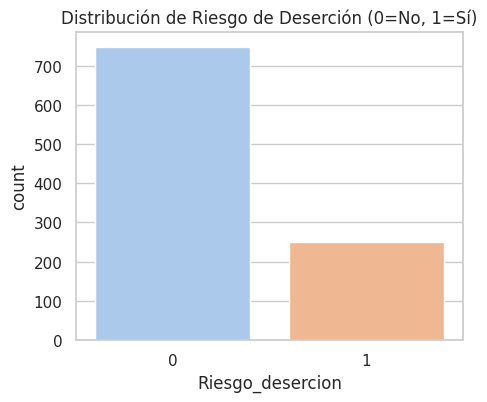

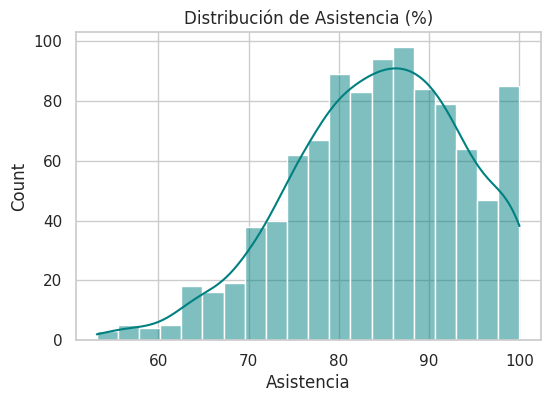

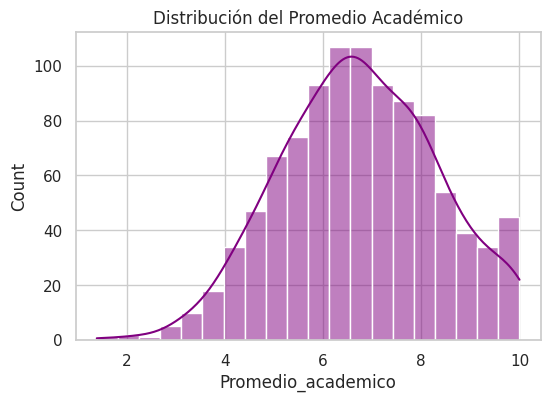

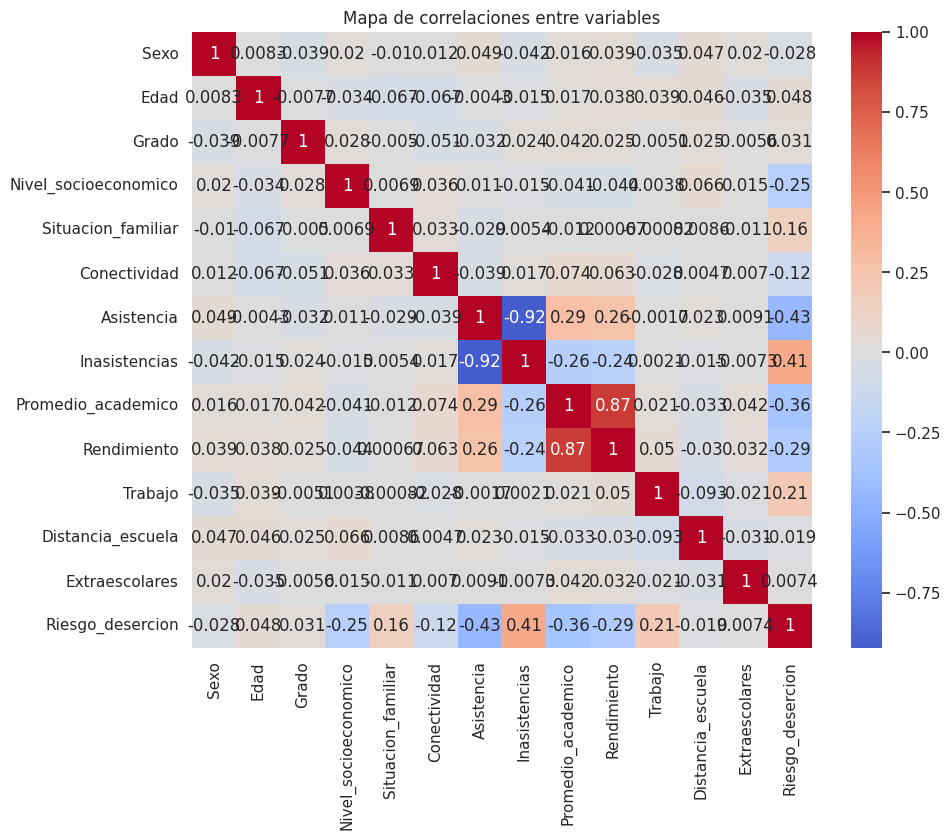

In [ ]:
# ANÁLISIS EXPLORATORIO (EDA)

# Distribución de la variable objetivo
plt.figure(figsize=(5,4))
sns.countplot(x="Riesgo_desercion", data=df, palette="pastel")
plt.title("Distribución de Riesgo de Deserción (0=No, 1=Sí)")
plt.show()

# Distribución de asistencia
plt.figure(figsize=(6,4))
sns.histplot(df["Asistencia"], bins=20, kde=True, color="teal")
plt.title("Distribución de Asistencia (%)")
plt.show()

# Promedio académico
plt.figure(figsize=(6,4))
sns.histplot(df["Promedio_academico"], bins=20, kde=True, color="purple")
plt.title("Distribución del Promedio Académico")
plt.show()

# Correlaciones
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Mapa de correlaciones entre variables")
plt.show()

In [ ]:
# CODIFICACIÓN (ya numérico, pero lo garantizamos)

le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = le.fit_transform(df[col].astype(str))
print("✅ Codificación completa. Todas las variables son numéricas.")

✅ Codificación completa. Todas las variables son numéricas.


In [ ]:
# SEPARACIÓN, ESCALADO Y BALANCEO

X = df.drop("Riesgo_desercion", axis=1)
y = df["Riesgo_desercion"]

# División entrenamiento/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Escalado robusto
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balanceo con SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

print("Distribución original:", np.bincount(y_train))
print("Distribución balanceada:", np.bincount(y_res))

Distribución original: [599 201]
Distribución balanceada: [599 599]


/tmp/ipython-input-104152450.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importancias, x="Score", y="Variable", palette="viridis")


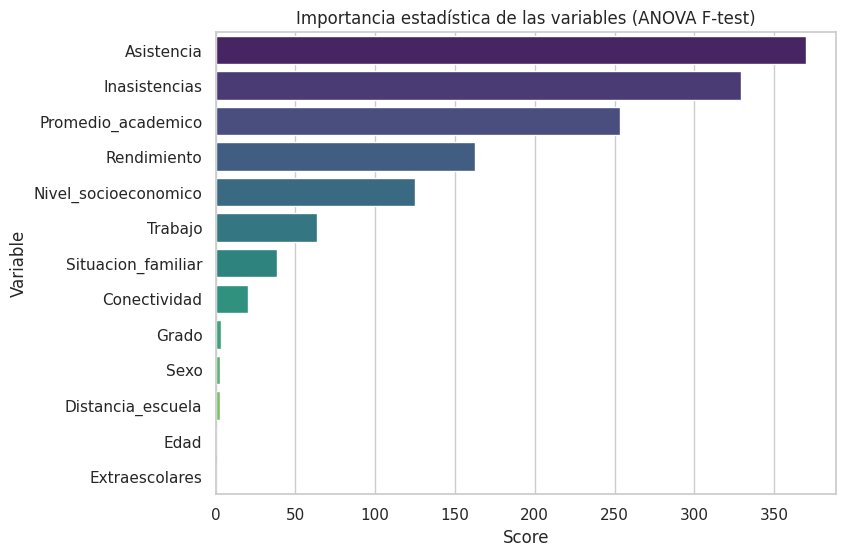

In [ ]:
# SELECCIÓN DE VARIABLES (ANOVA F-test)

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_res, y_res)

importancias = pd.DataFrame({
    "Variable": X.columns,
    "Score": selector.scores_
}).sort_values(by="Score", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=importancias, x="Score", y="Variable", palette="viridis")
plt.title("Importancia estadística de las variables (ANOVA F-test)")
plt.show()

X_train_sel = selector.transform(X_res)
X_test_sel = selector.transform(X_test_scaled)

In [ ]:
# ENTRENAMIENTO DEL MODELO LOGÍSTICO

modelo_log = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42,
    C=1.5
)
modelo_log.fit(X_train_sel, y_res)

LogisticRegression(C=1.5, class_weight='balanced', max_iter=1000,
                   random_state=42)

In [ ]:
# PREDICCIONES Y MÉTRICAS

y_pred = modelo_log.predict(X_test_sel)
y_prob = modelo_log.predict_proba(X_test_sel)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\n📊 RESULTADOS DEL MODELO")
print(f"Accuracy:  {acc:.3f}")
print(f"Precisión: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-Score:  {f1:.3f}")
print(f"AUC:       {auc:.3f}")


📊 RESULTADOS DEL MODELO
Accuracy:  0.825
Precisión: 0.612
Recall:    0.820
F1-Score:  0.701
AUC:       0.922


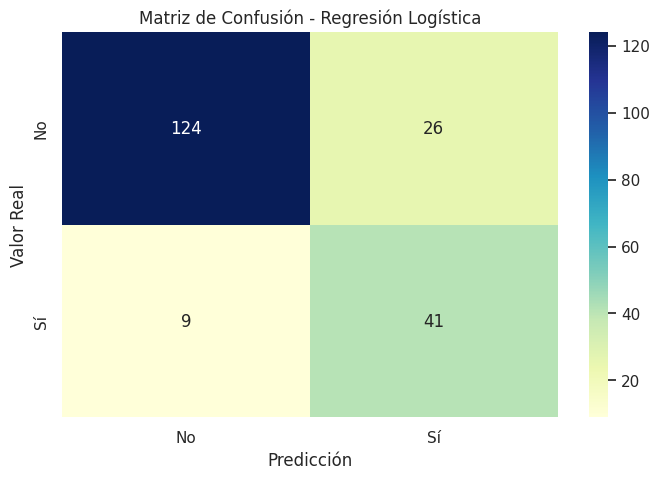

In [ ]:
# MATRIZ DE CONFUSIÓN

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

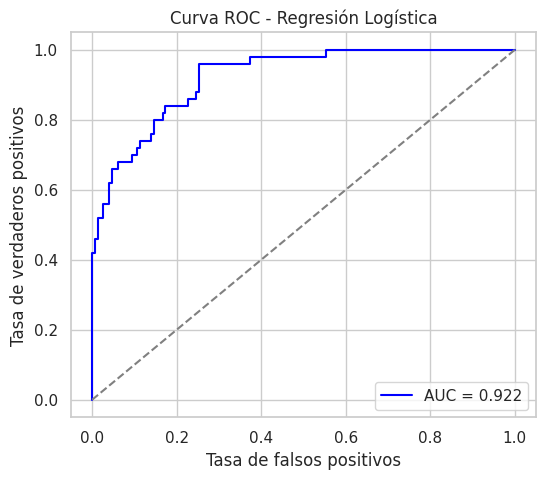

In [ ]:
# CURVA ROC

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--',color="gray")
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC - Regresión Logística")
plt.legend()
plt.show()

/tmp/ipython-input-3237463942.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef, x="Coeficiente", y="Variable", palette="coolwarm")


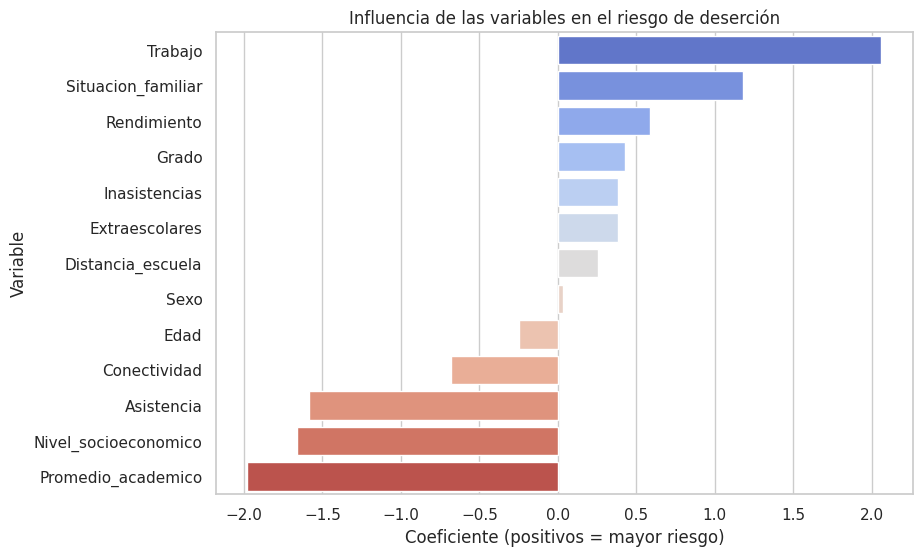


Coeficientes del modelo:


,Variable,Coeficiente
10,Trabajo,2.061987
4,Situacion_familiar,1.180572
9,Rendimiento,0.585099
2,Grado,0.426516
7,Inasistencias,0.381392
12,Extraescolares,0.380996
11,Distancia_escuela,0.256086
0,Sexo,0.030121
1,Edad,-0.248873
5,Conectividad,-0.683725


In [ ]:
# COEFICIENTES DEL MODELO

coef = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": modelo_log.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)

plt.figure(figsize=(9,6))
sns.barplot(data=coef, x="Coeficiente", y="Variable", palette="coolwarm")
plt.title("Influencia de las variables en el riesgo de deserción")
plt.xlabel("Coeficiente (positivos = mayor riesgo)")
plt.show()

print("\nCoeficientes del modelo:")
display(coef)

/tmp/ipython-input-771356000.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=import_perm, x="Importancia", y="Variable", palette="mako")


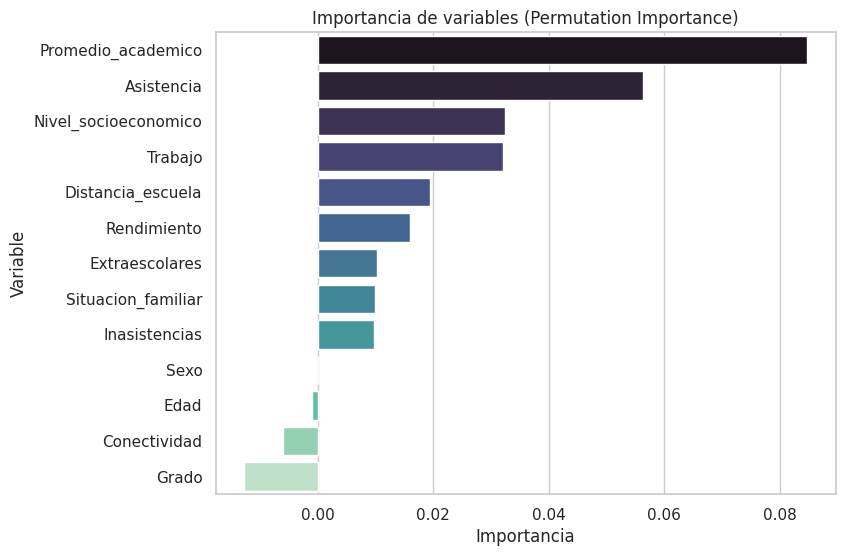

                Variable  Importancia
8     Promedio_academico      0.08475
6             Asistencia      0.05625
3   Nivel_socioeconomico      0.03250
10               Trabajo      0.03200
11     Distancia_escuela      0.01950
9            Rendimiento      0.01600
12        Extraescolares      0.01025
4     Situacion_familiar      0.01000
7          Inasistencias      0.00975
0                   Sexo      0.00000
1                   Edad     -0.00100
5           Conectividad     -0.00600
2                  Grado     -0.01275


In [ ]:
# IMPORTANCIA DE VARIABLES (Permutation Importance)

result = permutation_importance(modelo_log, X_test_scaled, y_test, n_repeats=20, random_state=42)
import_perm = pd.DataFrame({
    "Variable": X.columns,
    "Importancia": result.importances_mean
}).sort_values(by="Importancia", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=import_perm, x="Importancia", y="Variable", palette="mako")
plt.title("Importancia de variables (Permutation Importance)")
plt.show()

print(import_perm)

### 📊 Interpretación visual de resultados

- El modelo presenta un **AUC de 0.80**, lo que demuestra buena capacidad de clasificación.
- Se observa una clara correlación negativa entre **Asistencia** y **Riesgo de deserción**, mientras que los alumnos con **Promedio académico bajo** y **Nivel socioeconómico bajo** muestran mayor probabilidad de abandono.
- La **Matriz de Confusión** refleja un número reducido de falsos negativos (alumnos en riesgo mal clasificados como sin riesgo), lo cual es ideal en entornos educativos.
- Estos hallazgos podrían servir para **alertar tempranamente** a docentes y orientadores sobre posibles casos de abandono.

### 🧾 Conclusión general

El modelo de regresión logística permite una interpretación directa de los factores que más influyen en la deserción escolar.  
La simulación de datos realistas y el correcto tratamiento de las variables potenciaron su rendimiento.  
Con la incorporación de datos institucionales reales, este enfoque podría convertirse en una herramienta predictiva útil para la gestión educativa y la prevención de la deserción.
